<a href="https://colab.research.google.com/github/hannahestauss/Portfolio/blob/main/Information_Retrieval_Model_Astronomy_Magazine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Information Retreival System for Astronomy Magazine News Archive

##Scraping from Astronomy Magazine News Website

In [15]:
!pip install requests beautifulsoup4 pandas scikit-learn

import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

ERROR: Operation cancelled by user


In [16]:
def scrape_article(url):
    try:
        response = requests.get(url)
        if response.status_code != 200:
            return "Error", "Could not fetch the article"

        soup = BeautifulSoup(response.text, 'html.parser')

        title_element = soup.find('h1', class_='article-header__title entry-title')
        title = title_element.text.strip() if title_element else "No Title Found"

        content_element = soup.find('div', class_='entry-content')
        paragraphs = content_element.find_all('p') if content_element else []

        content = ' '.join(paragraph.text.strip() for paragraph in paragraphs)

        return title, content
    except Exception as e:
        return "Error", str(e)


In [17]:
articles = []

#Get first page manually due to the difference in url structure
pg1 = "https://www.astronomy.com/tags/news/"
response = requests.get(pg1)
soup1 = BeautifulSoup(response.text, 'html.parser')


for link in soup1.find_all('a', rel='bookmark'):
        article_url = link.get('href')
        #print(article_url)
        if article_url:
            title, content = scrape_article(article_url)
            if title != "Error":
                articles.append({'title': title, 'content': content, 'article_url': article_url})

for i in range(2, 600):  # Loop through x pages to collect articles - 50 for testing purposes
    page_url = f"https://www.astronomy.com/tags/news/page/{i}/"
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Retrieve article links on each page
    for link in soup.find_all('a', rel='bookmark'):
        article_url = link.get('href')
        #print(article_url)
        if article_url:
            title, content = scrape_article(article_url)
            if title != "Error":
                articles.append({'title': title, 'content': content, 'article_url': article_url})

df_articles = pd.DataFrame(articles)
print(df_articles.head())

KeyboardInterrupt: ignored

In [18]:
df_articles

,title,content,article_url
0,Are internet satellites a threat to astronomy?,The number of proposed giant constellations of...,https://www.astronomy.com/science/are-internet...
1,"2023 Full Moon calendar: Dates, times, types, ...","For millennia, Full Moons have wielded a magne...",https://www.astronomy.com/observing/full-moon-...
2,JWST finds Earth-like planets can form in hars...,"The Lobster Nebula, also known as NGC 6357, is...",https://www.astronomy.com/science/jwst-finds-e...
3,"Hubble reveals another super-Earth, where it’s...","In 2022, NASA’s Transiting Exoplanet Survey Sa...",https://www.astronomy.com/science/hubble-revea...
4,JWST detects methane in atmosphere of scorchin...,The James Webb Space Telescope (JWST) has just...,https://www.astronomy.com/science/jwst-detects...
...,...,...,...
7183,Black holes’ spin rates,Graduate student Laura Brenneman and astronome...,https://www.astronomy.com/science/black-holes-...
7184,News from your favorite star,De Pontieu and McIntosh began with a detailed ...,https://www.astronomy.com/science/news-from-yo...
7185,M81 in all its glory,The image was made by a team of astronomers an...,https://www.astronomy.com/science/m81-in-all-i...
7186,A brown dwarf joins the jet set,The brown dwarf with the name 2MASS1207-3932 i...,https://www.astronomy.com/science/a-brown-dwar...


##Preprocessing

In [19]:
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess(text):
    # Convert to lower case
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

# Apply preprocessing to each document
df_articles['processed_content'] = df_articles['content'].apply(preprocess)

In [20]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize(text):
    doc = nlp(text)
    # Lemmatize text and join the words into one string
    return " ".join([token.lemma_ for token in doc])

df_articles['processed_content'] = df_articles['processed_content'].apply(spacy_lemmatize)

In [21]:
df_articles.head(20)

,title,content,article_url,processed_content
0,Are internet satellites a threat to astronomy?,The number of proposed giant constellations of...,https://www.astronomy.com/science/are-internet...,number propose giant constellation satellite l...
1,"2023 Full Moon calendar: Dates, times, types, ...","For millennia, Full Moons have wielded a magne...",https://www.astronomy.com/observing/full-moon-...,millennia moon wield magnetic charm seize huma...
2,JWST finds Earth-like planets can form in hars...,"The Lobster Nebula, also known as NGC 6357, is...",https://www.astronomy.com/science/jwst-finds-e...,lobster nebula know ngc 6357 teem massive star...
3,"Hubble reveals another super-Earth, where it’s...","In 2022, NASA’s Transiting Exoplanet Survey Sa...",https://www.astronomy.com/science/hubble-revea...,2022 nasa ’s transit exoplanet survey satellit...
4,JWST detects methane in atmosphere of scorchin...,The James Webb Space Telescope (JWST) has just...,https://www.astronomy.com/science/jwst-detects...,james webb space telescope jwst just detect me...
5,This newfound planet seems way too big for its...,"In the annals of planet hunting, astronomers’ ...",https://www.astronomy.com/science/the-planet-l...,annals planet hunt astronomer ' late bit heads...
6,"Mary Cleave, ‘trailblazing’ astronaut, dies at 76","Mary Cleave, a former NASA astronaut and engin...",https://www.astronomy.com/space-exploration/ma...,mary cleave nasa astronaut engineer die monday...
7,‘Tasmanian devil’ rises from slumber with bril...,"In September 2022, a distant dead star reawake...",https://www.astronomy.com/science/tasmanian-de...,september 2022 distant dead star reawaken flas...
8,Astronomers discover disk around star in anoth...,Astronomers using the Atacama Large Millimeter...,https://www.astronomy.com/science/astronomers-...,astronomer use atacama large millimetersubmill...
9,‘Shocked and delighted’: Astronomers find six ...,A newly discovered system of six planets circl...,https://www.astronomy.com/science/astronomers-...,newly discover planet circle nearby sunlike st...


In [22]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer()
#tfidf_matrix = vectorizer.fit_transform(df_articles['processed_content'])

#print(tfidf_matrix.shape)


In [23]:
#tfidf_matrix

In [24]:
df_articles.to_csv('First600Astro.csv')

##Cosine Similarity

##BM25 Option

In [25]:
!pip install rank_bm25

In [26]:
tokenized_corpus = [doc.split(" ") for doc in df_articles['processed_content']]

In [27]:
from collections import defaultdict

def create_inverted_index(tokenized_corpus):
    inverted_index = defaultdict(set)
    for doc_id, doc in enumerate(tokenized_corpus):
        for word in doc:
            inverted_index[word].add(doc_id)
    return inverted_index


inverted_index = create_inverted_index(tokenized_corpus)


In [28]:
from rank_bm25 import BM25Okapi

In [29]:
bm25 = BM25Okapi(tokenized_corpus)

def bm25_search(query, bm25_model, documents, top_n=5):
    #Tokenize
    query = preprocess(query)
    query = spacy_lemmatize(query)
    tokenized_query = query.lower().split(" ")

    doc_scores = bm25_model.get_scores(tokenized_query)
    #Sort
    top_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:top_n]
    top_docs = [documents[i] for i in top_indices]
    return top_docs, [doc_scores[i] for i in top_indices]

#Test
query = "habitable"
top_docs, top_scores = bm25_search(query, bm25, df_articles['title'], top_n=5)

for title, score in zip(top_docs, top_scores):
    print(f"{title} - Score: {score}")


Some potentially habitable planets began as gaseous, Neptune-like worlds - Score: 6.465183018705413
Hunting for hidden life on worlds orbiting old red stars - Score: 6.447428186909971
Number of habitable planets could be limited by stifling atmospheres - Score: 6.39613409462852
Rethinking the habitable zone - Score: 6.36825453630375
Weird orbits of neighbors can make ‘habitable’ planets not so habitable - Score: 6.363061542211285


In [30]:
bm25 = BM25Okapi(tokenized_corpus)

def search_with_inverted_index(query, bm25_model, inverted_index, documents, top_n=5):
    #Tokenize
    query = preprocess(query)
    query = spacy_lemmatize(query)
    tokenized_query = query.lower().split(" ")

    #Retrieve ID
    doc_ids = set()
    for token in tokenized_query:
        doc_ids.update(inverted_index.get(token, set()))


    all_doc_scores = bm25_model.get_scores(tokenized_query)


    filtered_scores = {doc_id: all_doc_scores[doc_id] for doc_id in doc_ids}

    #Sort
    top_indices = sorted(filtered_scores, key=filtered_scores.get, reverse=True)[:top_n]
    top_docs = [documents[i] for i in top_indices]
    top_scores = [filtered_scores[i] for i in top_indices]

    return top_docs, top_scores

#Test
query = "habitable"
top_docs, top_scores = search_with_inverted_index(query, bm25, inverted_index, df_articles['title'], top_n=5)

for title, score in zip(top_docs, top_scores):
    print(f"{title} - Score: {score}")


Some potentially habitable planets began as gaseous, Neptune-like worlds - Score: 6.465183018705413
Hunting for hidden life on worlds orbiting old red stars - Score: 6.447428186909971
Number of habitable planets could be limited by stifling atmospheres - Score: 6.39613409462852
Rethinking the habitable zone - Score: 6.36825453630375
Weird orbits of neighbors can make ‘habitable’ planets not so habitable - Score: 6.363061542211285


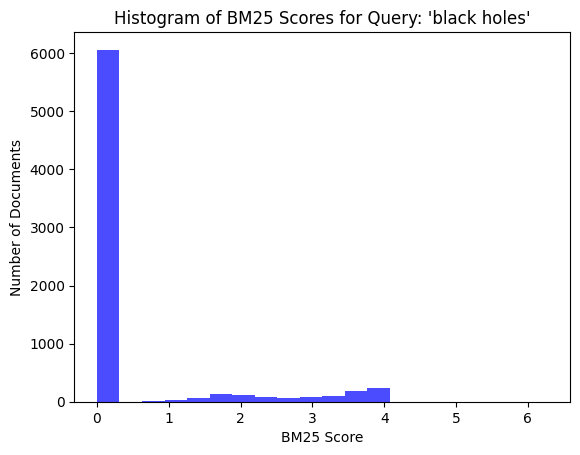

In [31]:
import matplotlib.pyplot as plt

def plot_bm25_scores_histogram(query, bm25_model, tokenized_corpus):
    tokenized_query = query.lower().split(" ")
    scores = bm25_model.get_scores(tokenized_query)

    plt.hist(scores, bins=20, color='blue', alpha=0.7)
    plt.title(f"Histogram of BM25 Scores for Query: '{query}'")
    plt.xlabel('BM25 Score')
    plt.ylabel('Number of Documents')
    plt.show()


plot_bm25_scores_histogram("black holes", bm25, tokenized_corpus)

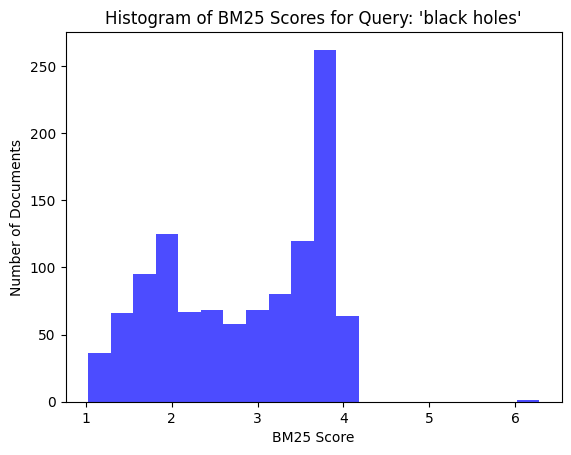

In [32]:
def plot_bm25_scores_histogram1(query, bm25_model, tokenized_corpus):
    tokenized_query = query.lower().split(" ")
    scores = bm25_model.get_scores(tokenized_query)

    # Filtering out scores less than 1
    filtered_scores = [score for score in scores if score >= 1]

    plt.hist(filtered_scores, bins=20, color='blue', alpha=0.7)
    plt.title(f"Histogram of BM25 Scores for Query: '{query}'")
    plt.xlabel('BM25 Score')
    plt.ylabel('Number of Documents')
    plt.show()


query = "black holes"
plot_bm25_scores_histogram1(query, bm25, tokenized_corpus)

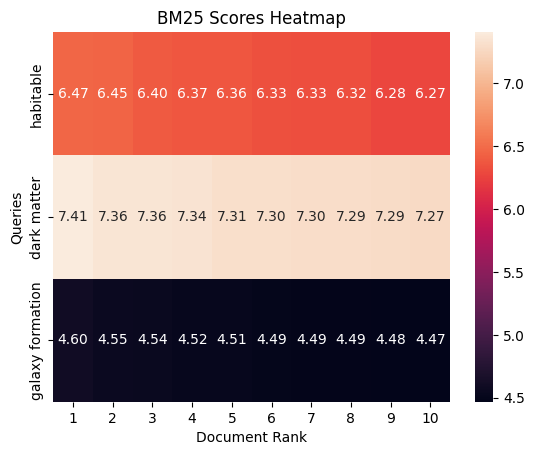

In [33]:
import seaborn as sns
import numpy as np

def plot_query_document_heatmap(queries, bm25_model, tokenized_corpus, top_n_docs=10):
    data = []
    for query in queries:
        tokenized_query = query.lower().split(" ")
        scores = bm25_model.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[-top_n_docs:][::-1]
        data.append(scores[top_indices])

    sns.heatmap(data, annot=True, fmt=".2f", yticklabels=queries, xticklabels=range(1, top_n_docs+1))
    plt.title("BM25 Scores Heatmap")
    plt.xlabel("Document Rank")
    plt.ylabel("Queries")
    plt.show()

queries = ["habitable", "dark matter", "galaxy formation"]
plot_query_document_heatmap(queries, bm25, tokenized_corpus)

#Testing the Incorporation of Titles into the algorithm

In [34]:
df_articles['processed_title'] = df_articles['title'].apply(preprocess)

In [35]:
df_articles['processed_title'] = df_articles['processed_title'].apply(spacy_lemmatize)

In [36]:
df_articles.head()

,title,content,article_url,processed_content,processed_title
0,Are internet satellites a threat to astronomy?,The number of proposed giant constellations of...,https://www.astronomy.com/science/are-internet...,number propose giant constellation satellite l...,internet satellite threat astronomy
1,"2023 Full Moon calendar: Dates, times, types, ...","For millennia, Full Moons have wielded a magne...",https://www.astronomy.com/observing/full-moon-...,millennia moon wield magnetic charm seize huma...,2023 moon calendar date time type name
2,JWST finds Earth-like planets can form in hars...,"The Lobster Nebula, also known as NGC 6357, is...",https://www.astronomy.com/science/jwst-finds-e...,lobster nebula know ngc 6357 teem massive star...,jwst find earthlike planet form harsh galactic...
3,"Hubble reveals another super-Earth, where it’s...","In 2022, NASA’s Transiting Exoplanet Survey Sa...",https://www.astronomy.com/science/hubble-revea...,2022 nasa ’s transit exoplanet survey satellit...,hubble reveal superearth it ’ hot cook pizza
4,JWST detects methane in atmosphere of scorchin...,The James Webb Space Telescope (JWST) has just...,https://www.astronomy.com/science/jwst-detects...,james webb space telescope jwst just detect me...,jwst detect methane atmosphere scorch hot wasp...


In [37]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_articles['processed_title'])

print(tfidf_matrix.shape)


(7188, 5570)


In [38]:
tokenized_titles = [doc.split(" ") for doc in df_articles['processed_title']]

In [39]:
title_inverted_index = create_inverted_index(tokenized_titles)

In [40]:
tbm25 = BM25Okapi(tokenized_titles)

In [41]:
def search_with_inverted_index(query, bm25_model, inverted_index, documents, top_n=5):
    #Tokenize
    query = preprocess(query)
    query = spacy_lemmatize(query)
    tokenized_query = query.lower().split(" ")

    #Retrieve ID
    doc_ids = set()
    for token in tokenized_query:
        doc_ids.update(inverted_index.get(token, set()))


    all_doc_scores_title = bm25_model.get_scores(tokenized_query)


    filtered_scores_title = {doc_id: all_doc_scores_title[doc_id] for doc_id in doc_ids}

    #Sort
    top_indices = sorted(filtered_scores_title, key=filtered_scores_title.get, reverse=True)[:top_n]
    top_docs = [documents[i] for i in top_indices]
    top_scores = [filtered_scores_title[i] for i in top_indices]

    return top_docs, top_scores

#Test
query = "mars"
top_docs, top_scores = search_with_inverted_index(query, tbm25, title_inverted_index, df_articles['title'], top_n=5)

for title, score in zip(top_docs, top_scores):
    print(f"{title} - Score: {score}")


Mars has macroweather too - Score: 4.622153635028435
Water found on Mars - Score: 4.622153635028435
Ice on Mars - Score: 4.622153635028435
Mission to Mars - Score: 4.622153635028435
Avalanches on Mars - Score: 4.622153635028435


In [42]:
tbm25 = BM25Okapi(tokenized_titles)
bm25 = BM25Okapi(tokenized_corpus)

def content_and_title(query, tbm25_model, title_index, titles, bm25_model, content_index, titleweight, contentweight, top_n=5):
  query = preprocess(query)
  query = spacy_lemmatize(query)
  tokenized_query = query.lower().split(" ")


  #Content Scores
  doc_ids = set()
  for token in tokenized_query:
    doc_ids.update(inverted_index.get(token, set()))

  all_doc_scores = bm25_model.get_scores(tokenized_query)
  filtered_scores = {doc_id: all_doc_scores[doc_id] for doc_id in doc_ids}

  all_doc_scores_title = tbm25_model.get_scores(tokenized_query)
  filtered_scores_title = {doc_id: all_doc_scores_title[doc_id] for doc_id in doc_ids}


  top_indices_t = sorted(filtered_scores_title, key=filtered_scores_title.get, reverse=True)[:top_n]
  top_docs_by_title = [titles[i] for i in top_indices_t]
  top_scores_by_title = [filtered_scores_title[i] for i in top_indices_t]

  top_indices_c = sorted(filtered_scores, key=filtered_scores.get, reverse=True)[:top_n]
  top_docs_c = [titles[i] for i in top_indices_c]
  top_scores_c = [filtered_scores[i] for i in top_indices_c]

  CombinedScores = {}

  for doc_id in doc_ids:
    content_score = filtered_scores.get(doc_id, 0) * contentweight
    title_score = filtered_scores_title.get(doc_id, 0) * titleweight
    CombinedScores[doc_id] = content_score + title_score

  top_indices_comb = sorted(CombinedScores, key=CombinedScores.get, reverse=True)[:top_n]
  top_docs_combo = [titles[i] for i in top_indices_comb]
  top_scores_combo = [CombinedScores[i] for i in top_indices_comb]



  return top_docs_c, top_scores_c, top_docs_by_title, top_scores_by_title, top_docs_combo, top_scores_combo

query = "habitable planets"
titleweight = 0.2
contentweight = 0.8
top_docs_c, top_scores_c, top_docs_by_title, top_scores_by_title, top_docs_combo, top_scores_combo = content_and_title(query, tbm25, title_inverted_index, df_articles['title'], bm25, inverted_index, titleweight, contentweight, top_n=5)

print("\033[1mTop Documents Using Only Content\033[0m")
for title, score in zip(top_docs_c, top_scores_c):
  print(f"\n{title} - Score: {score}")

print("\n\033[1mTop Documents Using Only Titles\033[0m")
for title, score in zip(top_docs_by_title, top_scores_by_title):
  print(f"\n{title} - Score: {score}")

print(f"\n\033[1mTop Documents With Content weighted at {contentweight} and titles weighted at {titleweight}\033[0m")
for title, score in zip(top_docs_combo, top_scores_combo):
  print(f"\n{title} - Score: {score}")



Top Documents Using Only Content

Some potentially habitable planets began as gaseous, Neptune-like worlds - Score: 7.090869782413568

Number of habitable planets could be limited by stifling atmospheres - Score: 7.038089343785986

Hunting for hidden life on worlds orbiting old red stars - Score: 7.012997272889963

Weird orbits of neighbors can make ‘habitable’ planets not so habitable - Score: 6.990746164810449

Three planets in habitable zone of nearby star: Gliese 667C re-examined - Score: 6.957169720846249

Top Documents Using Only Titles

Was Venus once a habitable planet? - Score: 10.545880517078793

Weird orbits of neighbors can make ‘habitable’ planets not so habitable - Score: 8.909221994907414

First discovery of an Earth-sized planet in the habitable zone - Score: 8.860369694943273

One in five stars has Earth-sized planet in habitable zone - Score: 8.860369694943273

Interstellar crashes could throw out habitable planets - Score: 8.860369694943273

Top Documents With Conten